# Evaluating Saturn-Titan L2 halos

In [115]:
import json
import numpy as np
import pykep as pk
from pykep.planet import jpl_lp
from pykep import epoch
import pygmo as pg
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from numba import njit

%matplotlib notebook

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
import sys
sys.path.append("../../polaris")
from polaris import Propagator as prop
from polaris import R3BP as r3bp

In [117]:
sys.path.append("../../trajplotlib")
import trajplotlib as tpl

In [118]:
with open("../data/saturn_titan_l2_haloN.json") as json_file:
    data = json.load(json_file)

In [64]:
data.keys()

dict_keys(['signature', 'system', 'count', 'family', 'branch', 'libration_point', 'limits', 'fields', 'data'])

In [65]:
data["system"]

{'L5': ['0.4997633606841668', '-0.8660254037844386', '0.0'],
 'radius_secondary': '2574.7',
 'name': 'Saturn-Titan',
 'L4': ['0.4997633606841668', '0.8660254037844386', '0.0'],
 'L1': ['0.9574961733241143', '0.0', '0.0'],
 'L2': ['1.043256421347392', '0.0', '0.0'],
 'lunit': '1195677.151917583',
 'L3': ['-1.00009859971421', '0.0', '0.0'],
 'tunit': '212238.2726842311',
 'mass_ratio': '2.366393158331484e-04'}

In [66]:
data["fields"]

['x', 'y', 'z', 'vx', 'vy', 'vz', 'jacobi', 'period', 'stability']

In [67]:
float(data["data"][0][7])

2.312500407598265

In [68]:
len(data["data"])

584

In [98]:
CR3BPparam = r3bp.CR3BP(699, 606)
# overwrite!
CR3BPparam.mu    = float(data["system"]["mass_ratio"])
CR3BPparam.lstar = float(data["system"]["lunit"])
CR3BPparam.tstar = float(data["system"]["tunit"])
CR3BPparam.vstar = CR3BPparam.lstar/CR3BPparam.tstar
CR3BPparam.m2_radius = float(data["system"]["radius_secondary"])/CR3BPparam.lstar
CR3BPparam.L1 = [float(el) for el in data["system"]["L1"]]
CR3BPparam.L2 = [float(el) for el in data["system"]["L2"]]
CR3BPparam.L3 = [float(el) for el in data["system"]["L3"]]
CR3BPparam.L4 = [float(el) for el in data["system"]["L4"]]
CR3BPparam.L5 = [float(el) for el in data["system"]["L5"]]

In [70]:
res = prop.propagate_cr3bp(
    CR3BPparam, 
    np.array([float(el) for el in data["data"][0][0:6]]), 
    float(data["data"][0][7])
)

In [106]:
def intersect_m2(t, state, mu):
    x,y,z = state[0:3]
    r2 = np.sqrt((x - 1 + mu) ** 2 + y ** 2)
    return r2 - CR3BPparam.m2_radius
intersect_m2.terminal = True
intersect_m2.direction = 0

In [107]:
res_list = []
for idx, dat in tqdm(enumerate(data["data"]), total=len(data['data'])):
    propout = prop.propagate_cr3bp(
        CR3BPparam, 
        np.array([float(el) for el in dat[0:6]]), 
        float(dat[7]),
        steps=100,
        events=(intersect_m2,),
    )
    res_list.append(
        propout
    )

  0%|          | 0/584 [00:00<?, ?it/s]

In [114]:
len(res_list[-1].eventTimes[0])

0

<IPython.core.display.Javascript object>


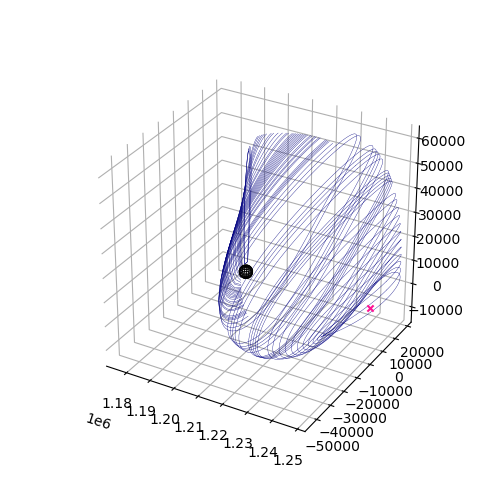

In [108]:
for idx, res in enumerate(res_list):
    if idx % 10 == 0:
        if idx == 0:
            fig, ax = tpl.quickplot3(res.xs*CR3BPparam.lstar, res.ys*CR3BPparam.lstar, res.zs*CR3BPparam.lstar, 
                                     lw_traj=0.25, scatter_start=False, scatter_end=False)
        else:
            tpl.quickplot3(res.xs*CR3BPparam.lstar, res.ys*CR3BPparam.lstar, res.zs*CR3BPparam.lstar, 
                           ax=ax, lw_traj=0.25, scatter_start=False, scatter_end=False)

tpl.plot_sphere_wireframe(ax, radius=CR3BPparam.m2_radius*CR3BPparam.lstar, 
                          center=[(1-CR3BPparam.mu)*CR3BPparam.lstar,0.0,0.0])
          
ax.scatter(CR3BPparam.L2[0]*CR3BPparam.lstar, CR3BPparam.L2[1]*CR3BPparam.lstar, CR3BPparam.L2[2]*CR3BPparam.lstar, 
           marker="x", c="deeppink")
plt.show()